In [3]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
#from sklearn.cross_validation import KFold # use for cross validation
#sklearn.model_selectionが新しいバージョンなのでここは使用しない
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

Using TensorFlow backend.


In [4]:
df = pd.read_csv('./input/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')
#この段階において"nan"や"?"のような欠損値はnumpy nanに変換されている
#また"Date"と"Time"は"dt"という一つの列に結合されている
#infer_datetime_formatは列データがdatetimeのフォーマットになっているか確認することで時系列データとしてインデックスラベルを変更す

In [5]:
df.head()#先頭の情報を示す
df.info()#このデータについての情報をまとめて示す
df.shape#データの形状を示す
df.describe()#データについての統計情報を述べる

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7)
memory usage: 126.7 MB


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


欠損値"nan"を統計情報を利用して埋める

In [6]:
dropping_list_all = []#欠損値を持っている列を記録する
for col in df.columns:#すべての列に対して捜索する
    if not df[col].notnull().all():#colという列は少なくとも1つは欠損値を持っているとき
        dropping_list_all.append(col)#colを追加する
print(dropping_list_all)#すべての列が欠損値を持っていることが分かった

['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


In [7]:
for col in dropping_list_all:#欠損値を持っている列について
    df[col] = df[col].fillna(df[col].mean())#欠損値を持っている位置はその列の平均で置き換える(適当すぎでは?)
    #もっと本気でやろうと思えば線形補完が必要かもしれない
df.isnull().sum()#欠損値の個数を列ごとに表示する、なぜ列ごとの情報が出てくるのかは不明、便利

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

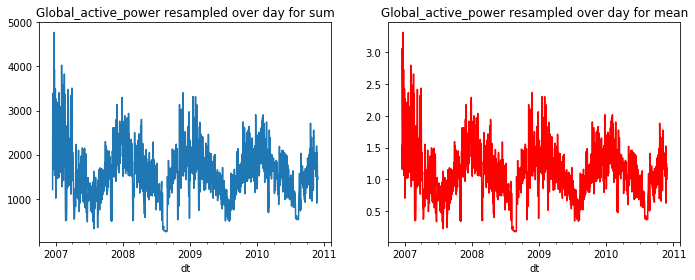

In [8]:
fig=plt.figure(facecolor='w',figsize = (10,4))#ダークモード中で軸をなくさないためにfacecolorが必要、figsizeは並べたときのサイズをよくするため
plt.subplot(1,2,1)#横に並べるために必要
df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum') #日付ごとにリサンプルし、日ごとの合計を取ってプロットする。よくわからない
plt.tight_layout()#これの意味もよくわからない
plt.subplot(1,2,2)
df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean', color='red') 
plt.subplots_adjust(wspace = 0.6)#resample("D")だけではprintすることができない、sumやmeanで集約する必要がある
plt.tight_layout()
plt.show()

In [11]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,t0 = 2):#n_inは(t-n_in,...,t-t0)までのデータを用いるということ,n_outは(t,...,t+n_out-1)までを予測するということ)
	n_vars = 1 if type(data) is list else data.shape[1]#n_varsは変数の数,dataがlistのときはshapeだとうまくいかないから場合分け
	dff = pd.DataFrame(data)#list形式のときのためデータフレームに直した?
	cols, names = list(), list()#とりあえずからのリストをつくる
	# input sequence (t-n, ... t-1)
	for i in range(n_in, t0-1, -1):#inputについてのデータを作りcolsに格納,あとで結合。名前も保存
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]#変数名もいい感じに付ける
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):#outputについてのデータも作りcolsに格納
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]#t+0はダサイので場合分け
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)#colsの変数たちを保存する
	agg.columns = names#名前についても結合する
	# drop rows with NaN values
	if dropnan:#nanが入っている列があれば削除する
		agg.dropna(inplace=True)
	return agg

In [36]:
values = df.values[:,0:2]#Gloval_active_powerとその次のみを取り出した,最初だけではscaler.fit_transformが動かない
prediction = np.roll(values,t0,axis = 0)
print(values)
print(prediction)
values = prediction-values#valuesは素朴な予測値の誤差になる
print(values)

[[4.216 0.418]
 [5.36  0.436]
 [5.374 0.498]
 ...
 [0.938 0.   ]
 [0.934 0.   ]
 [0.932 0.   ]]
[[0.934 0.   ]
 [0.932 0.   ]
 [4.216 0.418]
 ...
 [0.946 0.   ]
 [0.944 0.   ]
 [0.938 0.   ]]
[[-3.282 -0.418]
 [-4.428 -0.436]
 [-1.158 -0.08 ]
 ...
 [ 0.008  0.   ]
 [ 0.01   0.   ]
 [ 0.006  0.   ]]


In [37]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))#0から1の間で規格化するインスタンスを作成?
scaled = scaler.fit_transform(values)#実際に規格化
# frame as supervised learning
M = 10
reframed = series_to_supervised(scaled, M, 1,t0)#この場合t-1を利用してtを予測することになる
#reframed.drop(reframed.columns[[1,3,5,7,9,11,13,15,17,19,21]], axis=1, inplace=True)#scaler.fit_trainsformのために追加したものを削除する
reframed.drop(reframed.columns[[2*i+1 for i in range(M+2-t0)]], axis=1, inplace=True)#scaler.fit_trainsformのために追加したものを削除する
reframed.head()

,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t)
10,0.229827,0.130527,0.413871,0.511784,0.662208,0.676071,0.511091,0.498614,0.517157,0.446624
11,0.130527,0.413871,0.511784,0.662208,0.676071,0.511091,0.498614,0.517157,0.517503,0.362574
12,0.413871,0.511784,0.662208,0.676071,0.511091,0.498614,0.517157,0.517503,0.446624,0.446971
13,0.511784,0.662208,0.676071,0.511091,0.498614,0.517157,0.517503,0.446624,0.362574,0.526688
14,0.662208,0.676071,0.511091,0.498614,0.517157,0.517503,0.446624,0.362574,0.446971,0.615590


In [41]:
values = reframed.values#またnp.arrayに変換し直す、何のため?
n_train_time = 60*24*30*12#一か月分のデータを利用する
n_test_time = n_train_time+int(n_train_time*0.3)#30%分のテストデータを取り出す
train = values[:n_train_time]
test = values[n_train_time:n_test_time]
train_X,train_y = train[:,:-1],train[:,-1]#一番最後の列だけ(右端)目的とする値y、他は予測のために利用する値X
test_X,test_y = test[:,:-1],test[:,-1]
#LSTMsを利用するために形を整える必要がある
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape(len(train_X),len(train_X[0]),1)
train_X = train_X.reshape(len(train_X),1,M+1-t0)
test_X = test_X.reshape(len(test_X),1,M+1-t0)
print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)

(518400, 1, 9) (518400,) (155520, 1, 9) (155520,)


Train on 518400 samples, validate on 155520 samples
Epoch 1/20
 - 38s - loss: 0.0020 - val_loss: 0.0012
Epoch 2/20
 - 27s - loss: 0.0013 - val_loss: 0.0012
Epoch 3/20
 - 29s - loss: 0.0013 - val_loss: 0.0012
Epoch 4/20
 - 54s - loss: 0.0013 - val_loss: 0.0012
Epoch 5/20
 - 53s - loss: 0.0013 - val_loss: 0.0012
Epoch 6/20
 - 53s - loss: 0.0013 - val_loss: 0.0012
Epoch 7/20
 - 54s - loss: 0.0013 - val_loss: 0.0012
Epoch 8/20
 - 75s - loss: 0.0013 - val_loss: 0.0012
Epoch 9/20
 - 95s - loss: 0.0013 - val_loss: 0.0012
Epoch 10/20
 - 94s - loss: 0.0013 - val_loss: 0.0012
Epoch 11/20
 - 90s - loss: 0.0013 - val_loss: 0.0012
Epoch 12/20
 - 92s - loss: 0.0013 - val_loss: 0.0012
Epoch 13/20
 - 90s - loss: 0.0013 - val_loss: 0.0012
Epoch 14/20
 - 95s - loss: 0.0013 - val_loss: 0.0012
Epoch 15/20
 - 91s - loss: 0.0013 - val_loss: 0.0012
Epoch 16/20
 - 91s - loss: 0.0013 - val_loss: 0.0012
Epoch 17/20
 - 91s - loss: 0.0013 - val_loss: 0.0012
Epoch 18/20
 - 90s - loss: 0.0013 - val_loss: 0.0012
Epo

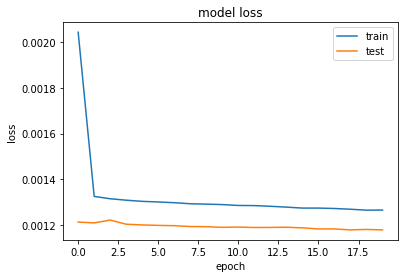

In [42]:
model = Sequential()#時系列データに対するやつ
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#model.add(LSTM(100))
#model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

#fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

#summarize histry for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


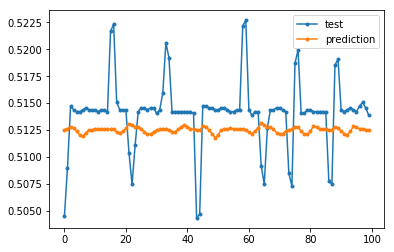

In [45]:
aa = [x for x in range(100)]
plt.plot(aa,test_y[400:500],label = "test",marker = ".")
plt.plot(aa,model.predict(test_X)[400:500],label = "prediction",marker = ".")
plt.legend()
plt.show()

In [48]:
#make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))
test_X.shape

(155520, 9)

In [58]:
#予測値を逆戻しする
inv_yhat = np.concatenate((yhat,yhat),axis = 1)#2つめのyhatは適当
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_yhat = prediction[:,0][n_train_time:n_test_time]+inv_yhat

In [59]:
#実際の値を逆戻しする
inv_y = df.values[:,0][n_train_time:n_test_time]
rmse = np.sqrt(mean_squared_error(inv_y,inv_yhat))
print("RMSE = %.3f" % rmse)

RMSE = 0.398


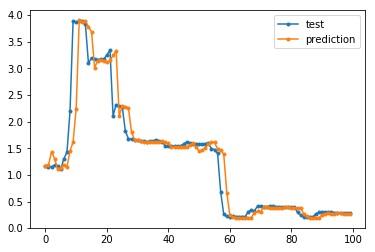

In [61]:
aa = [x for x in range(100)]
plt.plot(aa,inv_y[300:400],label = "test",marker = ".")
plt.plot(aa,inv_yhat[300:400],label = "prediction",marker = ".")
plt.legend()
plt.show()

In [62]:
inv_yhat = prediction[:,0][n_train_time:n_test_time]
inv_y = df.values[:,0][n_train_time:n_test_time]
rmse = np.sqrt(mean_squared_error(inv_y,inv_yhat))
print("RMSE = %.3f" % rmse)

RMSE = 0.410
